* time spent on 1 epoch drops significantly with larger batch (but this 'cancels out' with slowed down convergence)
* most of the time is spent in actual work (run_backward)
* even so, why is calculating derivatives taking so much time?

In [1]:
import pstats
from pstats import SortKey

In [2]:
p_b16 = pstats.Stats('stats-b16')
p_b16.strip_dirs().sort_stats(SortKey.TIME).print_stats(10)

Thu Dec 12 09:59:46 2019    stats-b16

         1167475 function calls (1153867 primitive calls) in 124.407 seconds

   Ordered by: internal time
   List reduced from 3712 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     3240  109.744    0.034  109.744    0.034 {method 'run_backward' of 'torch._C._EngineBase' objects}
        1    5.685    5.685  123.423  123.423 pde.py:395(solve2D_system)
   234000    2.341    0.000    2.341    0.000 profiled.py:160(<genexpr>)
     1950    2.023    0.001    6.897    0.004 profiled.py:170(interpolate_by_thin_plate_spline)
    83450    1.284    0.000    3.634    0.000 {built-in method builtins.sum}
    78000    0.866    0.000    4.478    0.000 profiled.py:159(_ri_sq_thin_plate_spline_trainval)
     1300    0.437    0.000   45.205    0.035 neurodiffeq.py:5(diff)
    78000    0.388    0.000    0.388    0.000 {built-in method log}
    50/48    0.303    0.006    0.305    0.006 {built-in method _imp.

In [3]:
p_b16 = pstats.Stats('stats-b256')
p_b16.strip_dirs().sort_stats(SortKey.TIME).print_stats(10)

Fri Dec 13 10:22:44 2019    stats-b256

         597493 function calls (587485 primitive calls) in 10.349 seconds

   Ordered by: internal time
   List reduced from 3712 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      240    8.540    0.036    8.540    0.036 {method 'run_backward' of 'torch._C._EngineBase' objects}
        1    0.512    0.512    9.688    9.688 pde.py:395(solve2D_system)
    18000    0.180    0.000    0.180    0.000 profiled.py:160(<genexpr>)
      150    0.158    0.001    0.535    0.004 profiled.py:170(interpolate_by_thin_plate_spline)
    50/48    0.116    0.002    0.118    0.002 {built-in method _imp.create_dynamic}
    10850    0.102    0.000    0.284    0.000 {built-in method builtins.sum}
     6000    0.065    0.000    0.343    0.000 profiled.py:159(_ri_sq_thin_plate_spline_trainval)
      502    0.064    0.000    0.064    0.000 {built-in method marshal.loads}
      100    0.036    0.000    4.036    0.040

In [4]:
# both torch.autograd.grad and tensor.backward calls run_backward. Which is the one taking the most time?
# torch.autograd.grad: called in neurodiffeq.diff (calc derivative terms in ode/pde ('s loss))
# tensor.backward: called in neurodiffeq.ode/pde.solve (calc derivative w.r.t. ANN weights)
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.ode import IVP, Monitor, solve_system
from neurodiffeq.pde import solve2D, ExampleGenerator2D, Monitor2D
from custombc import Point, DirichletControlPoint, CustomDirichletBoundaryCondition
import timeit

In [5]:
BATCH_SIZE_SQRT = 16
train_gen = ExampleGenerator2D((BATCH_SIZE_SQRT, BATCH_SIZE_SQRT), (0, 0), (1, 1), method='equally-spaced-noisy')
x_train, y_train = train_gen.get_examples()
x_train, y_train = x_train.reshape((-1, 1)), y_train.reshape((-1, 1))

In [6]:
control_points_square = []
for i in np.linspace(0, 1, 11):
    control_points_square.append(DirichletControlPoint(loc=(0, i), val=0))
for i in np.linspace(0, 1, 11):
    control_points_square.append(DirichletControlPoint(loc=(1, i), val=0))
for i in np.linspace(1, 0, 11):
    control_points_square.append(DirichletControlPoint(loc=(i, 0), val=0))
for i in np.linspace(0, 1, 11):
    control_points_square.append(DirichletControlPoint(loc=(i, 1), val=0))
    
cdbc = CustomDirichletBoundaryCondition( control_points_square, center_point=Point((0.5, 0.5)) )

In [7]:
def poisson(u, x, y): 
    return diff(u, x, order=2) + diff(u, y, order=2) - 2*x*(y-1)*(y-2*x+x*y+2)*torch.exp(x-y)

In [8]:
# timing torch.autograd.grad
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1)
u = net(torch.cat((x_train, y_train), 1))
u_tilde = cdbc.enforce(net, x_train, y_train)
%timeit residual = poisson(u_tilde, x_train, y_train)

77.4 ms ± 571 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1)

In [10]:
%%timeit
# timing torch.autograd.grad and tensor.backward 
u = net(torch.cat((x_train, y_train), 1))
u_tilde = cdbc.enforce(net, x_train, y_train)
residual = poisson(u_tilde, x_train, y_train)
zeros_train = torch.zeros_like(u_tilde)
mse = torch.nn.MSELoss()
loss = mse(residual, zeros_train)
loss.backward()

204 ms ± 5.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
n_points_per_edge = range(3, 21)
tspent_grad = []
tspent_backward = []
REPEAT = 10
for n in n_points_per_edge:
    control_points_square = []
    for i in np.linspace(0, 1, n):
        control_points_square.append(DirichletControlPoint(loc=(0, i), val=0))
    for i in np.linspace(0, 1, n):
        control_points_square.append(DirichletControlPoint(loc=(1, i), val=0))
    for i in np.linspace(1, 0, n):
        control_points_square.append(DirichletControlPoint(loc=(i, 0), val=0))
    for i in np.linspace(0, 1, n):
        control_points_square.append(DirichletControlPoint(loc=(i, 1), val=0))
    cdbc = CustomDirichletBoundaryCondition( control_points_square, center_point=Point((0.5, 0.5)) )
    
    # timing code that involves autograd.grad
    total_grad = 0.0
    for _ in range(REPEAT):
        net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1)
        u = net(torch.cat((x_train, y_train), 1))
        u_tilde = cdbc.enforce(net, x_train, y_train)
        
        start_time = timeit.default_timer()
        residual = poisson(u_tilde, x_train, y_train)   
        end_time = timeit.default_timer()
        
        total_grad += end_time- start_time
    tspent_grad.append(total_grad/REPEAT)
    
    # timing code that involves tensor.backward
    total_backward = 0.0
    for _ in range(REPEAT):
        u = net(torch.cat((x_train, y_train), 1))
        u_tilde = cdbc.enforce(net, x_train, y_train)
        residual = poisson(u_tilde, x_train, y_train)
        zeros_train = torch.zeros_like(u_tilde)
        mse = torch.nn.MSELoss()
        loss = mse(residual, zeros_train)
        
        start_time = timeit.default_timer()
        loss.backward()
        end_time = timeit.default_timer()
        
        total_backward += end_time- start_time
    tspent_backward.append(total_backward/REPEAT)

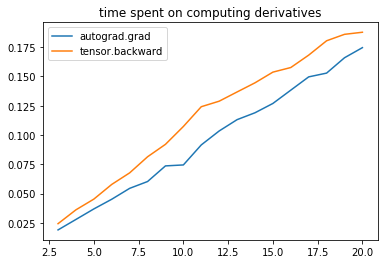

In [12]:
plt.plot(n_points_per_edge, tspent_grad, label='autograd.grad')
plt.plot(n_points_per_edge, tspent_backward, label='tensor.backward')
plt.title('time spent on computing derivatives')
plt.legend();